In [1]:
import math
import torch
import gpytorch
import spectralgp
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.set_default_dtype(torch.float64)
seed = np.random.randint(42)
print(seed)
torch.random.manual_seed(seed)

30


#### Processing training Data

Here we setup a function to load training data as well as randomly split the data for train/test.

In [4]:
def read_data(dataset, only_scale = False, **kwargs):
    D = loadmat("../exps_multi_input_dim/data/{}.mat".format(dataset))
    data = np.array(D['data'])
    train_x, test_x, train_y, test_y = train_test_split(data[:, :-1], data[:, -1], test_size=0.10, random_state=np.random.randint(10000))
    
    test_x = (test_x - np.mean(train_x, axis=0))/(np.std(train_x, axis=0)+1e-17)
    train_x = (train_x - np.mean(train_x, axis=0))/(np.std(train_x, axis=0)+1e-17)

    
    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y)
    test_x = torch.tensor(test_x)
    test_y = torch.tensor(test_y)

    y_std_train = torch.std(train_y)
    y_std_full = torch.std(torch.cat([train_y, test_y]))

    return train_x, train_y, test_x, test_y, y_std_full, y_std_train, _

In [5]:
dataset = 'servo2'

print("Dataset: {}".format(dataset))
train_x, train_y, test_x, test_y, y_std, y_std_train, gen_kern = read_data(dataset)
in_dims = 1 if train_x.dim() == 1 else train_x.size(1)

Dataset: servo2


#### GPU support

If CUDA is available, we can simply just change the datatypes of the training/test tensor to the appropriate datatype.

In [6]:
use_cuda = torch.cuda.is_available()
print('Cuda is available', use_cuda)
if use_cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    train_x, train_y, test_x, test_y, y_std = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda(), y_std.cuda()
    if gen_kern is not None:
        gen_kern = gen_kern.cuda()

print("Input Dimensions {}".format(in_dims))

Cuda is available False
Input Dimensions 4



#### Set up the GPyTorch Model with Spectral Product GP kernel

Using the same framework as standard GPyTorch models, we merely drop-in the product spectral GP kernel as the covar module.

For specifics on the components of GPyTorch models we refer to the [GPyTorch Documentation](https://gpytorch.readthedocs.io/en/latest/index.html)


In [7]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, shared, **kwargs):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = spectralgp.kernels.ProductSpectralGPKernel(train_x, train_y, shared, **kwargs)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-3))
model = ExactGPModel(train_x, train_y, likelihood, shared=False, 
                     normalize = False, symmetrize = False, num_locs = 100,
                     spacing='random', pretrain=False, period_factor=36.)

Using LogRBF latent mean
Using LogRBF latent mean
Using LogRBF latent mean
Using LogRBF latent mean


#### Setup Sampling Factories and Alternating Sampler

In the inference procedure we consider fixing the latent GP observation and doing gradient descent updates on the hyperparameters, then fixing the hyperparameters and using elliptical slice sampling to update the latent GP.

The ss_factory generates a "factory" that fixes the latent GP and computes the loss function of the hyperparameters

In [9]:
alt_sampler = spectralgp.samplers.AlternatingSampler(
    [model], [likelihood], 
    spectralgp.sampling_factories.ss_factory, [spectralgp.sampling_factories.ess_factory],
    totalSamples=20, numInnerSamples=5, numOuterSamples=5,
    num_dims=in_dims
    )

In [10]:
alt_sampler.run()

Step:  0 Dimension:  0
Loss is:  tensor(-111.4021, grad_fn=<DivBackward0>)
Loss is:  tensor(-109.6780, grad_fn=<DivBackward0>)
Loss is:  tensor(-108.0121, grad_fn=<DivBackward0>)
Loss is:  tensor(-106.4655, grad_fn=<DivBackward0>)
Loss is:  tensor(-104.8221, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  1
Loss is:  tensor(-96.2047, grad_fn=<DivBackward0>)
Loss is:  tensor(-94.8235, grad_fn=<DivBackward0>)
Loss is:  tensor(-93.4246, grad_fn=<DivBackward0>)
Loss is:  tensor(-92.0357, grad_fn=<DivBackward0>)
Loss is:  tensor(-90.6443, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  2
Loss is:  tensor(-84.6287, grad_fn=<DivBackward0>)
Loss is:  tensor(-83.3075, grad_fn=<DivBackward0>)
Loss is:  tensor(-82.1060, grad_fn=<DivBackward0>)
Loss is:  tensor(-80.8417, grad_fn=<DivBackward0>)
Loss is:  tensor(-79.5856, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  3
Loss is:  tensor(-74.5897, grad_fn=<DivBackward0>)
Loss is:  tensor(-73.

Loss is:  tensor(-12.9928, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.8309, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 6
Step:  6 Dimension:  3
Loss is:  tensor(-12.6159, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.4568, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.3095, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.1555, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.0041, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 6
Seconds for Iteration 6 : 10.57735276222229
Step:  7 Dimension:  0
Loss is:  tensor(-11.8600, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.7166, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.5813, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.4250, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.2991, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 7
Step:  7 Dimension:  1
Loss is:  tensor(-11.1266, grad_fn=<DivBackward0>)
Loss is:  tensor(-10.9956, grad_fn=<DivBackward0>)
Loss is:  tensor(-10.8709, grad_fn=<DivBackward0>)
Loss is:  tensor(-10.7378, grad_fn=<DivBackward0>)
Loss 

Loss is:  tensor(-3.5076, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.5015, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.4986, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.4418, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 13
Step:  13 Dimension:  2
Loss is:  tensor(-3.5120, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.4936, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.4733, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.4634, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.4459, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 13
Step:  13 Dimension:  3
Loss is:  tensor(-3.3528, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.3194, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.2962, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.3101, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.2776, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 13
Seconds for Iteration 13 : 11.450801849365234
Step:  14 Dimension:  0
Loss is:  tensor(-3.2792, grad_fn=<DivBackward0>)
Loss is:  tensor(-3.2540, grad_fn=<DivBackward0>)
Loss is:  ten

Seconds for Iteration 19 : 11.745217084884644


In [11]:


model.eval()
likelihood.eval()

d = model(test_x).mean - test_y

test_rmse = torch.sqrt(torch.mean(torch.pow(d, 2)))
print("Test RMSE: {}".format(test_rmse))

y_preds = likelihood(model(test_x))
y_var = y_preds.variance

nll = 0.5 * torch.log(2. * math.pi * y_var) +  torch.pow((model(test_x).mean - test_y),2)/(2. * y_var)
nll_sum = nll.sum()
print("NLL: {}".format(nll_sum))

sll = nll - (0.5 * torch.log(2. * math.pi * torch.pow(y_std_train, 2)) +  torch.pow((torch.mean(train_y) - test_y),2)/(2. * torch.pow(y_std_train, 2)))
msll = torch.mean(sll)
print("MSLL: {}".format(msll))


Test RMSE: 0.2918290064831801
NLL: 3.8321189953269132
MSLL: -1.2464192537144607


In [12]:
alt_sampler.gsampled[0].size()

torch.Size([1, 100, 100])

Text(0.5, 1.0, 'Spectral Densities by Dimension, Servo')

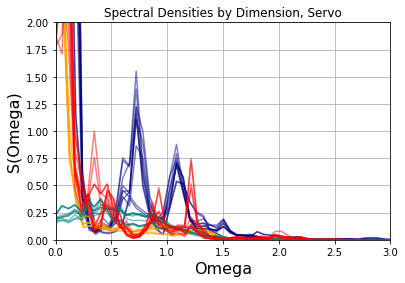

In [13]:
colors = ['navy', 'orange', 'teal', 'red']

for dim in range(in_dims):
    # get last 10 samples for current dimension
    dim_samples = alt_sampler.gsampled[dim][0, :,-10:]
    
    omega = model.covar_module.get_omega(dim).cpu().numpy()
    
    plt.plot(omega, dim_samples.exp().cpu().numpy(), color=colors[dim], alpha = 0.5)
plt.grid()

plt.xlabel('Omega', fontsize=16)
plt.ylabel('S(Omega)', fontsize = 16)
plt.xlim((0, 3))
plt.ylim((0, 2))
plt.title('Spectral Densities by Dimension, Servo')